### Import Libraries

In [25]:
from sqlalchemy import create_engine
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import imblearn.over_sampling
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
import time


### Import dataset from AWS, Postgress, and DBeaver

In [3]:
cnx = create_engine('postgresql://ubuntu@35.153.71.122:5432/apple')

In [4]:
df = pd.read_sql_query('''SELECT * FROM appleinfo''', cnx)

### Pickle dataset from DBeaver

In [24]:
df.to_pickle('appledata.pkl')

In [3]:
test_df = pd.read_pickle('appledata.pkl')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             7197 non-null   int64  
 1   id                7197 non-null   int64  
 2   app_name          7197 non-null   object 
 3   size_bytes        7197 non-null   object 
 4   currency          7197 non-null   object 
 5   price             7197 non-null   float64
 6   rating_count      7197 non-null   int64  
 7   rating_count_ver  7197 non-null   int64  
 8   user_rating       7197 non-null   float64
 9   userrating_ver    7197 non-null   object 
 10  ver               7197 non-null   object 
 11  content_rating    7197 non-null   object 
 12  prime_genre       7197 non-null   object 
 13  support_devices   7197 non-null   int64  
 14  ipad_screenshot   7197 non-null   int64  
 15  lang_num          7197 non-null   int64  
 16  vpp_lic           7197 non-null   int64  


In [15]:
new_df = df.drop('index', 1)

In [14]:
df[df.rating_count == df.rating_count.max()]

,index,id,app_name,size_bytes,currency,price,rating_count,rating_count_ver,user_rating,userrating_ver,ver,content_rating,prime_genre,support_devices,ipad_screenshot,lang_num,vpp_lic
16,17,284882215,Facebook,389879808,USD,0.0,2974676,212,3.5,3.5,95.0,4+,Social Networking,37,1,29,1


In [13]:
df.rating_count.max()

2974676

In [16]:
new_df.rating_

,id,price,rating_count,rating_count_ver,user_rating,support_devices,ipad_screenshot,lang_num,vpp_lic
count,7.197000e+03,7197.000000,7.197000e+03,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000
mean,8.631310e+08,1.726218,1.289291e+04,460.373906,3.526956,37.361817,3.707100,5.434903,0.993053
std,2.712368e+08,5.833006,7.573941e+04,3920.455183,1.517948,3.737715,1.986005,7.919593,0.083066
min,2.816565e+08,0.000000,0.000000e+00,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000
25%,6.000937e+08,0.000000,2.800000e+01,1.000000,3.500000,37.000000,3.000000,1.000000,1.000000
50%,9.781482e+08,0.000000,3.000000e+02,23.000000,4.000000,37.000000,5.000000,1.000000,1.000000
75%,1.082310e+09,1.990000,2.793000e+03,140.000000,4.500000,38.000000,5.000000,8.000000,1.000000
max,1.188376e+09,299.990000,2.974676e+06,177050.000000,5.000000,47.000000,5.000000,75.000000,1.000000


In [19]:
new_df.app_name.nunique()

7195

In [20]:
new_df

,id,app_name,size_bytes,currency,price,rating_count,rating_count_ver,user_rating,userrating_ver,ver,content_rating,prime_genre,support_devices,ipad_screenshot,lang_num,vpp_lic
0,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5,7.5.1,4+,Reference,37,5,45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,1187617475,Kubik,126644224,USD,0.00,142,75,4.5,4.5,1.3,4+,Games,38,5,1,1
7193,1187682390,VR Roller-Coaster,120760320,USD,0.00,30,30,4.5,4.5,0.9,4+,Games,38,0,1,1
7194,1187779532,Bret Michaels Emojis + Lyric Keyboard,111322112,USD,1.99,15,0,4.5,0,1.0.2,9+,Utilities,37,1,1,1
7195,1187838770,VR Roller Coaster World - Virtual Reality,97235968,USD,0.00,85,32,4.5,4.5,1.0.15,12+,Games,38,0,2,1


In [27]:
test_df.isnull().sum()

index               0
id                  0
app_name            0
size_bytes          0
currency            0
price               0
rating_count        0
rating_count_ver    0
user_rating         0
userrating_ver      0
ver                 0
content_rating      0
prime_genre         0
support_devices     0
ipad_screenshot     0
lang_num            0
vpp_lic             0
dtype: int64

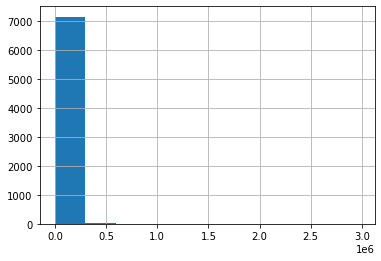

In [29]:
test_df.rating_count.hist(bins=10)

In [34]:
top_app = test_df[test_df.rating_count > 10000]

#### Create a column with apps over 10,000 reviews are popular

In [4]:
def popular(x):
    if x.rating_count >= 10000:
        return 1
    else:
        return 0 

In [41]:
top_app['popular'] = top_app.apply(lambda x: popular(x), axis=1)

<ipython-input-41-212cec09e8f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_app['popular'] = top_app.apply(lambda x: popular(x), axis=1)


In [5]:
test_df['popular'] = test_df.apply(lambda x: popular(x), axis=1)

In [6]:
test_df

,index,id,app_name,size_bytes,currency,price,rating_count,rating_count_ver,user_rating,userrating_ver,ver,content_rating,prime_genre,support_devices,ipad_screenshot,lang_num,vpp_lic,popular
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5,7.5.1,4+,Reference,37,5,45,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,11081,1187617475,Kubik,126644224,USD,0.00,142,75,4.5,4.5,1.3,4+,Games,38,5,1,1,0
7193,11082,1187682390,VR Roller-Coaster,120760320,USD,0.00,30,30,4.5,4.5,0.9,4+,Games,38,0,1,1,0
7194,11087,1187779532,Bret Michaels Emojis + Lyric Keyboard,111322112,USD,1.99,15,0,4.5,0,1.0.2,9+,Utilities,37,1,1,1,0
7195,11089,1187838770,VR Roller Coaster World - Virtual Reality,97235968,USD,0.00,85,32,4.5,4.5,1.0.15,12+,Games,38,0,2,1,0


In [7]:
test_df['content_rating'] = test_df['content_rating'].str.replace('+', '')

In [8]:
test_df['content_rating'] = test_df['content_rating'].astype(float)

In [9]:
column = ['size_bytes', 'userrating_ver']
test_df[column] = test_df[column].astype(float)

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             7197 non-null   int64  
 1   id                7197 non-null   int64  
 2   app_name          7197 non-null   object 
 3   size_bytes        7197 non-null   float64
 4   currency          7197 non-null   object 
 5   price             7197 non-null   float64
 6   rating_count      7197 non-null   int64  
 7   rating_count_ver  7197 non-null   int64  
 8   user_rating       7197 non-null   float64
 9   userrating_ver    7197 non-null   float64
 10  ver               7197 non-null   object 
 11  content_rating    7197 non-null   float64
 12  prime_genre       7197 non-null   object 
 13  support_devices   7197 non-null   int64  
 14  ipad_screenshot   7197 non-null   int64  
 15  lang_num          7197 non-null   int64  
 16  vpp_lic           7197 non-null   int64  


In [104]:
test_df.groupby(['popular', 'user_rating']).user_rating.count()

popular  user_rating
0        0.0             929
         1.0              44
         1.5              56
         2.0             103
         2.5             184
         3.0             352
         3.5             614
         4.0            1448
         4.5            2039
         5.0             412
1        2.0               3
         2.5              12
         3.0              31
         3.5              88
         4.0             178
         4.5             624
         5.0              80
Name: user_rating, dtype: int64

In [31]:
test_df.corr()

,index,id,size_bytes,price,rating_count,rating_count_ver,user_rating,userrating_ver,content_rating,support_devices,ipad_screenshot,lang_num,vpp_lic,popular
index,1.000000,0.910714,0.041277,-0.074326,-0.168640,-0.064717,-0.204867,-0.127580,0.011980,0.024648,0.014589,-0.148487,0.000501,-0.323969
id,0.910714,1.000000,0.077486,-0.075247,-0.201976,-0.072784,-0.185178,-0.109849,0.023500,0.033605,0.052082,-0.128932,0.017743,-0.355037
size_bytes,0.041277,0.077486,1.000000,0.182392,0.004486,0.006337,0.066256,0.086075,0.140541,-0.118347,0.152697,0.004614,-0.150418,0.009694
price,-0.074326,-0.075247,0.182392,1.000000,-0.039044,-0.018012,0.046601,0.025173,-0.029666,-0.115361,0.066100,-0.006713,-0.029942,-0.075736
rating_count,-0.168640,-0.201976,0.004486,-0.039044,1.000000,0.163645,0.083310,0.088744,0.009139,0.008832,0.015734,0.137675,-0.000982,0.385637
rating_count_ver,-0.064717,-0.072784,0.006337,-0.018012,0.163645,1.000000,0.068754,0.077840,0.001435,0.037951,0.024333,0.013287,0.006460,0.202063
user_rating,-0.204867,-0.185178,0.066256,0.046601,0.083310,0.068754,1.000000,0.774140,-0.097999,-0.042451,0.265671,0.170976,0.069816,0.203386
userrating_ver,-0.127580,-0.109849,0.086075,0.025173,0.088744,0.077840,0.774140,1.000000,-0.120357,-0.018901,0.275737,0.175580,0.050094,0.207077
content_rating,0.011980,0.023500,0.140541,-0.029666,0.009139,0.001435,-0.097999,-0.120357,1.000000,0.020085,-0.107726,-0.069508,-0.044961,0.004002
support_devices,0.024648,0.033605,-0.118347,-0.115361,0.008832,0.037951,-0.042451,-0.018901,0.020085,1.000000,-0.037728,-0.041681,-0.037109,0.013495


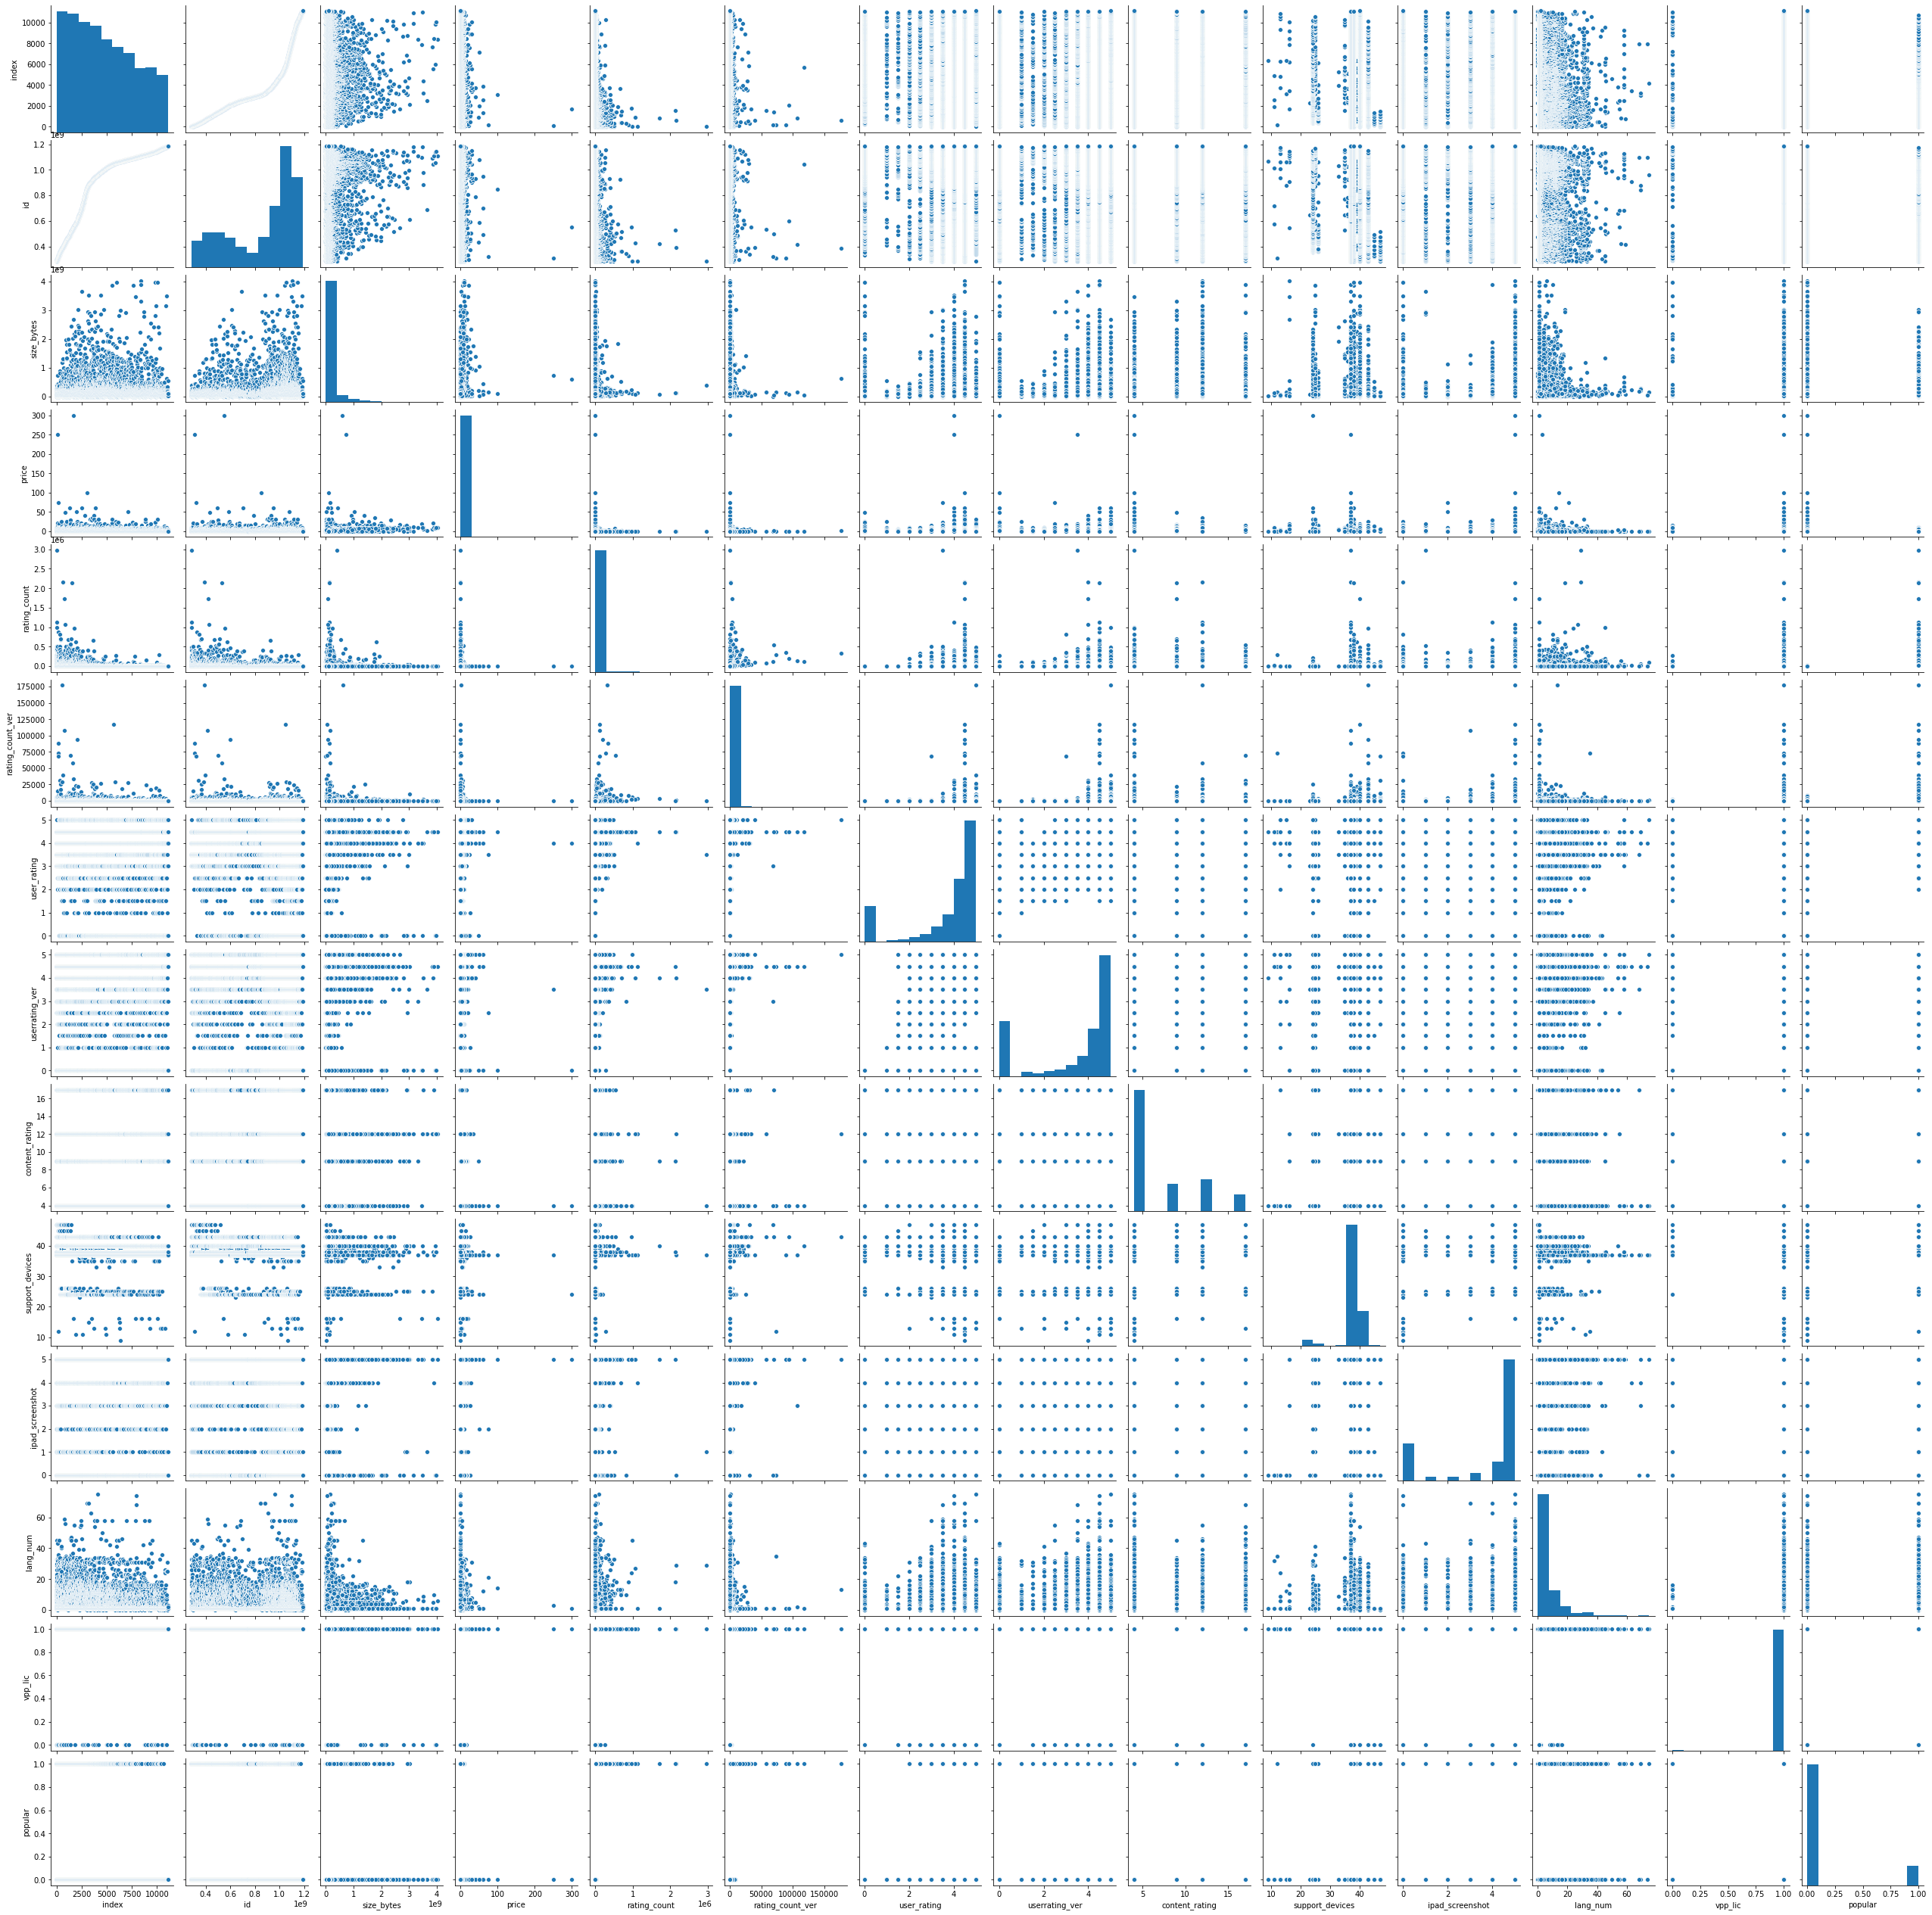

In [34]:
sns.pairplot(test_df)

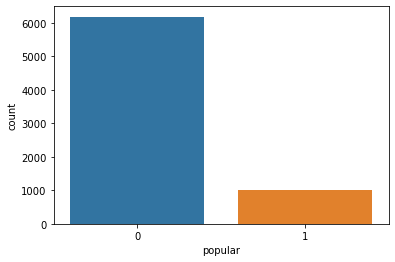

In [195]:
sns.countplot(test_df.popular)

In [216]:
test_df.describe()

,index,id,size_bytes,price,rating_count,rating_count_ver,user_rating,userrating_ver,content_rating,support_devices,ipad_screenshot,lang_num,vpp_lic,popular
count,7197.000000,7.197000e+03,7.197000e+03,7197.000000,7.197000e+03,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000
mean,4759.069612,8.631310e+08,1.991345e+08,1.726218,1.289291e+04,460.373906,3.526956,3.253578,7.093094,37.361817,3.707100,5.434903,0.993053,0.141170
std,3093.625213,2.712368e+08,3.592069e+08,5.833006,7.573941e+04,3920.455183,1.517948,1.809363,4.329046,3.737715,1.986005,7.919593,0.083066,0.348221
min,1.000000,2.816565e+08,5.898240e+05,0.000000,0.000000e+00,0.000000,0.000000,0.000000,4.000000,9.000000,0.000000,0.000000,0.000000,0.000000
25%,2090.000000,6.000937e+08,4.692275e+07,0.000000,2.800000e+01,1.000000,3.500000,2.500000,4.000000,37.000000,3.000000,1.000000,1.000000,0.000000
50%,4380.000000,9.781482e+08,9.715302e+07,0.000000,3.000000e+02,23.000000,4.000000,4.000000,4.000000,37.000000,5.000000,1.000000,1.000000,0.000000
75%,7223.000000,1.082310e+09,1.819249e+08,1.990000,2.793000e+03,140.000000,4.500000,4.500000,9.000000,38.000000,5.000000,8.000000,1.000000,0.000000
max,11097.000000,1.188376e+09,4.025970e+09,299.990000,2.974676e+06,177050.000000,5.000000,5.000000,17.000000,47.000000,5.000000,75.000000,1.000000,1.000000


In [191]:
test_df.loc[:, ['content_rating','ipad_screenshot','price', 'lang_num','support_devices', 'popular']].corr()

,content_rating,ipad_screenshot,price,lang_num,support_devices,popular
content_rating,1.000000,-0.107726,-0.029666,-0.069508,0.020085,0.004002
ipad_screenshot,-0.107726,1.000000,0.066100,0.088378,-0.037728,0.052162
price,-0.029666,0.066100,1.000000,-0.006713,-0.115361,-0.075736
lang_num,-0.069508,0.088378,-0.006713,1.000000,-0.041681,0.204291
support_devices,0.020085,-0.037728,-0.115361,-0.041681,1.000000,0.013495
popular,0.004002,0.052162,-0.075736,0.204291,0.013495,1.000000


/Users/michaelpaig/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


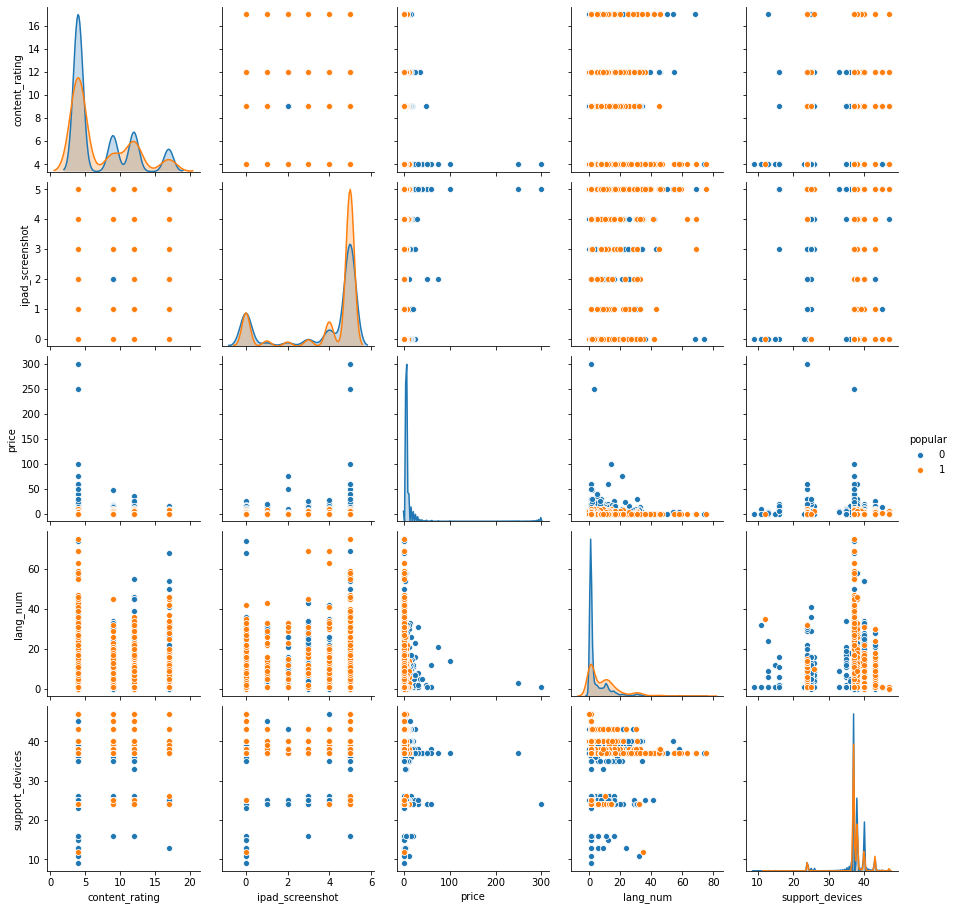

In [188]:
sns.pairplot(test_df.loc[:, ['content_rating','ipad_screenshot','price', 'lang_num','support_devices', 'popular']], hue='popular')


#### Turn genre into dummy categories

In [69]:
dummy = pd.get_dummies(test_df.prime_genre, drop_first=True)

In [74]:
dummy

,Business,Catalogs,Education,Entertainment,Finance,Food & Drink,Games,Health & Fitness,Lifestyle,Medical,...,News,Photo & Video,Productivity,Reference,Shopping,Social Networking,Sports,Travel,Utilities,Weather
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7193,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7195,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
df2 = test_df.copy()

### Merge into final dataset

In [86]:
df3 = df2.merge(dummy, left_index=True, right_index=True)

In [83]:
dummy.columns

Index(['Business', 'Catalogs', 'Education', 'Entertainment', 'Finance',
       'Food & Drink', 'Games', 'Health & Fitness', 'Lifestyle', 'Medical',
       'Music', 'Navigation', 'News', 'Photo & Video', 'Productivity',
       'Reference', 'Shopping', 'Social Networking', 'Sports', 'Travel',
       'Utilities', 'Weather'],
      dtype='object')

In [326]:
df3.drop('mult', axis=1, inplace=True)

#### Pickle the final dataset

In [2]:
df3 = pd.read_pickle('latest_df.pkl')

In [3]:
df3

,index,id,app_name,size_bytes,currency,price,rating_count,rating_count_ver,user_rating,userrating_ver,...,Productivity,Reference,Shopping,Social Networking,Sports,Travel,Utilities,Weather,Paid/Free,version
0,1,281656475,PAC-MAN Premium,100788224.0,USD,3.99,21292,26,4.0,4.5,...,0,0,0,0,0,0,0,0,1,6
1,2,281796108,Evernote - stay organized,158578688.0,USD,0.00,161065,26,4.0,3.5,...,1,0,0,0,0,0,0,0,0,8
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032.0,USD,0.00,188583,2822,3.5,4.5,...,0,0,0,0,0,0,0,1,0,5
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000.0,USD,0.00,262241,649,4.0,4.5,...,0,0,1,0,0,0,0,0,0,5
4,5,282935706,Bible,92774400.0,USD,0.00,985920,5320,4.5,5.0,...,0,1,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,11081,1187617475,Kubik,126644224.0,USD,0.00,142,75,4.5,4.5,...,0,0,0,0,0,0,0,0,0,1
7193,11082,1187682390,VR Roller-Coaster,120760320.0,USD,0.00,30,30,4.5,4.5,...,0,0,0,0,0,0,0,0,0,0
7194,11087,1187779532,Bret Michaels Emojis + Lyric Keyboard,111322112.0,USD,1.99,15,0,4.5,0.0,...,0,0,0,0,0,0,1,0,1,1
7195,11089,1187838770,VR Roller Coaster World - Virtual Reality,97235968.0,USD,0.00,85,32,4.5,4.5,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df3['price']

0       3.99
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
7192    0.00
7193    0.00
7194    1.99
7195    0.00
7196    0.00
Name: price, Length: 7197, dtype: float64

### Test models on base model

In [5]:
Target = df3['popular']
Features = (df3[['price','content_rating','ipad_screenshot', 'lang_num', 
                 'support_devices', 'Education', 'Entertainment', 'Games']])

In [6]:
Features, Features_test, Target, Target_test = train_test_split(Features, Target, test_size=.2, random_state=14) 

Features, Target = np.array(Features), np.array(Target)

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 39)

f1_log, f1_knn, f1_svc, f1_rfc, f1_dc, f1_gb  = [], [], [], [], [], []
r_log, r_knn, r_svc, r_rfc, r_dc, r_gb = [], [], [], [], [], []
p_log, p_knn, p_svc, p_rfc, p_dc, p_gb = [], [], [], [], [], []
roc_log, roc_knn, roc_svc, roc_rfc, roc_dc, roc_gb = [], [], [], [], [], []


for train_ind, val_ind in skf.split(Features, Target):
    
    Features_train, Target_train = Features[train_ind], Target[train_ind]
    Features_val, Target_val = Features[val_ind], Target[val_ind] 
    
    n_pos = np.sum(Target_train == 1)
    n_neg = np.sum(Target_train == 0)
    ratio = {1 : n_pos * 6, 0 : n_neg}
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    Features_train, Target_train = ROS.fit_sample(Features_train, Target_train)

    #scaler
    scaler = StandardScaler()
    Features_train_scaled = scaler.fit_transform(Features_train)
    Features_val_scaled = scaler.transform(Features_val)
    
    #KNN 
    knn = KNeighborsClassifier()
    knn.fit(Features_train_scaled, Target_train)
    train_predict = knn.predict(Features_val_scaled)
    p_knn.append(precision_score(Target_val, train_predict))
    f1_knn.append(f1_score(Target_val, train_predict))
    r_knn.append(recall_score(Target_val, train_predict))
    roc_knn.append(roc_auc_score(Target_val, knn.predict_proba(Features_val_scaled)[:,1]))
    
    #logistic regression
    lm = LogisticRegression()
    lm.fit(Features_train_scaled, Target_train)
    train_predict = (lm.predict_proba(Features_val_scaled)[:, 1] > 0.5)
    p_log.append(precision_score(Target_val, train_predict))
    f1_log.append(f1_score(Target_val, train_predict))
    r_log.append(recall_score(Target_val, train_predict))
    roc_log.append(roc_auc_score(Target_val, lm.predict_proba(Features_val_scaled)[:,1]))
    
    #SVC
    svc = SVC()
    svc.fit(Features_train, Target_train)
    train_predict = svc.predict(Features_val)
    p_svc.append(precision_score(Target_val, train_predict))
    f1_svc.append(f1_score(Target_val, train_predict))
    r_svc.append(recall_score(Target_val, train_predict))
    roc_svc.append(roc_auc_score(Target_val, knn.predict_proba(Features_val)[:,1]))
    
    #Randomforest
    rfc = RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=100, criterion='entropy')
    rfc.fit(Features_train, Target_train)
    train_predict = (rfc.predict_proba(Features_val)[:, 1] > 0.50)
    p_rfc.append(precision_score(Target_val, train_predict))
    f1_rfc.append(f1_score(Target_val, train_predict))
    r_rfc.append(recall_score(Target_val, train_predict))
    roc_rfc.append(roc_auc_score(Target_val, rfc.predict_proba(Features_val)[:,1]))
    
    #dummy model
    dummy_clf = DummyClassifier()
    dummy_clf.fit(Features_train, Target_train)
    train_predict = dummy_clf.predict(Features_val)
    p_dc.append(precision_score(Target_val, train_predict))
    f1_dc.append(f1_score(Target_val, train_predict))
    r_dc.append(recall_score(Target_val, train_predict))
    roc_dc.append(roc_auc_score(Target_val, dummy_clf.predict_proba(Features_val)[:,1]))
    
    #gaussian bayes
    gb = GaussianNB()
    gb.fit(Features_train, Target_train)
    train_predict = gb.predict(Features_val)
    p_gb.append(precision_score(Target_val, train_predict))
    f1_gb.append(f1_score(Target_val, train_predict))
    r_gb.append(recall_score(Target_val, train_predict))
    roc_gb.append(roc_auc_score(Target_val, gb.predict_proba(Features_val)[:,1]))
    


/Users/michaelpaig/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/michaelpaig/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/michaelpaig/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/michaelpaig/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change fro

In [23]:
print(f'Log F1: {np.mean(f1_log):.3f}')
print(f'KNN F1: {np.mean(f1_knn):.3f}')
print(f'SVC F1: {np.mean(f1_svc):.3f}')
print(f'Dummy F1: {np.mean(f1_dc):.3f}')
print(f'Gaussian Bayes F1: {np.mean(f1_gb):.3f}')
print(f'RandomForest F1: {np.mean(f1_rfc,):.3f}', '\n')

print(f'Log precision: {np.mean(p_log):.3f}')
print(f'KNN precision: {np.mean(p_knn):.3f}')
print(f'SVC precision: {np.mean(p_knn):.3f}')
print(f'Dummyy precision: {np.mean(p_dc):.3f}')
print(f'Gaussian precision: {np.mean(p_gb):.3f}')
print(f'RandomForest precision: {np.mean(p_rfc):.3f}', '\n')

print(f'Log recall: {np.mean(r_log):.3f}')
print(f'KNN recall: {np.mean(r_knn):.3f}')
print(f'SVC recall: {np.mean(r_svc):.3f}')
print(f'Dummy recall: {np.mean(r_dc):.3f}')
print(f'Gaussian recall: {np.mean(r_gb):.3f}')
print(f'RandomForest recall: {np.mean(r_rfc):.3f}', '\n')

print(f'Log roc auc: {np.mean(roc_log):.3f}')
print(f'KNN roc auc: {np.mean(roc_knn):.3f}')
print(f'SVC roc auc: {np.mean(roc_svc):.3f}')
print(f'Dummy roc auc: {np.mean(roc_dc):.3f}')
print(f'Gaussian roc auc: {np.mean(roc_gb):.3f}')
print(f'RandomForest roc auc: {np.mean(roc_rfc):.3f}', '\n')


Log F1: 0.342
KNN F1: 0.324
SVC F1: 0.364
Dummy F1: 0.219
Gaussian Bayes F1: 0.273
RandomForest F1: 0.394 

Log precision: 0.234
KNN precision: 0.258
SVC precision: 0.258
Dummyy precision: 0.141
Gaussian precision: 0.162
RandomForest precision: 0.291 

Log recall: 0.647
KNN recall: 0.437
SVC recall: 0.508
Dummy recall: 0.487
Gaussian recall: 0.859
RandomForest recall: 0.617 

Log roc auc: 0.712
KNN roc auc: 0.677
SVC roc auc: 0.457
Dummy roc auc: 0.488
Gaussian roc auc: 0.682
RandomForest roc auc: 0.766 



In [402]:
rfc.feature_importances_

array([0.32323482, 0.06270107, 0.06638669, 0.33471464, 0.08922006,
       0.06030361, 0.00932656, 0.05411255])

In [259]:
rfc.feature_importances_

array([0.21334925, 0.09084869, 0.10382555, 0.36245222, 0.15473155,
       0.01945111, 0.01361981, 0.0417218 ])

In [ ]:
#### ROC Curve

In [20]:
fpr, tpr, thresholds = roc_curve(Target_train, rfc.predict_proba(Features_train)[:,1])

ROC AUC score =  0.7268195005045408


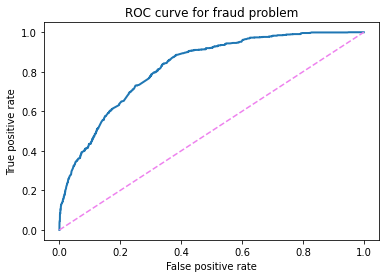

In [21]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(Target_val, rfc.predict_proba(Features_val)[:,1]))

#### Use GridsearchCV to find optimal hypterparameters

In [379]:
grid = { "n_estimators": [100,200,500],
           "criterion": ["gini", "entropy"],
           "max_features": ['sqrt','log2',0.2,0.5,0.8],
           "max_depth": [3,4,6,10]
         }

rf_grid = RandomForestClassifier()
grid_search = GridSearchCV(rf_grid, grid, n_jobs=-1, cv=5)

start = time.time()
grid_search.fit(Features, Target)
end = time.time()

print("Tune Fit Time:", end - start)

Tune Fit Time: 236.03566193580627


In [301]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.8,
 'n_estimators': 200}

In [380]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'log2',
 'n_estimators': 100}

In [303]:
rf_grid = RandomForestClassifier(max_depth=10, max_features=0.8, n_estimators=200, criterion='gini')
cross_val_score(rf_grid, Features_train, Target_train, scoring='precision').mean()

0.7770126169702481

#### Try XGboost on my model

In [369]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(Features_train, Target_train),(Features_val,Target_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    Features_train, Target_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=False #gives output log as below
                   )

[14:41:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1588600962499/work/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49140	validation_1-rmse:0.49067
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.48445	validation_1-rmse:0.48324
[2]	validation_0-rmse:0.47896	validation_1-rmse:0.47743
[3]	validation_0-rmse:0.47591	validation_1-rmse:0.47382
[4]	validation_0-rmse:0.47110	validation_1-rmse:0.46837
[5]	validation_0-rmse:0.46725	validation_1-rmse:0.46400
[6]	validation_0-rmse:0.46510	validation_1-rmse:0.46126
[7]	validation_0-rmse:0.46225	validation_1-rmse:0.45859
[8]	validation_0-rmse:0.46031	validation_1-rmse:0.45634
[9]	validation_0-rmse:0.45765	validation_1-rmse:0.45369
[10]	validation_0-rmse:0.45614	validation_1-rmse:0.45198
[11]	validation_0-rmse:0.45421	validation_1-rm

[138]	validation_0-rmse:0.41711	validation_1-rmse:0.42793
[139]	validation_0-rmse:0.41703	validation_1-rmse:0.42773
[140]	validation_0-rmse:0.41690	validation_1-rmse:0.42773
[141]	validation_0-rmse:0.41674	validation_1-rmse:0.42770
[142]	validation_0-rmse:0.41657	validation_1-rmse:0.42771
[143]	validation_0-rmse:0.41654	validation_1-rmse:0.42766
[144]	validation_0-rmse:0.41637	validation_1-rmse:0.42772
[145]	validation_0-rmse:0.41619	validation_1-rmse:0.42782
[146]	validation_0-rmse:0.41605	validation_1-rmse:0.42799
[147]	validation_0-rmse:0.41603	validation_1-rmse:0.42799
[148]	validation_0-rmse:0.41595	validation_1-rmse:0.42799
[149]	validation_0-rmse:0.41587	validation_1-rmse:0.42791
[150]	validation_0-rmse:0.41583	validation_1-rmse:0.42787
[151]	validation_0-rmse:0.41577	validation_1-rmse:0.42781
[152]	validation_0-rmse:0.41556	validation_1-rmse:0.42789
[153]	validation_0-rmse:0.41553	validation_1-rmse:0.42787
[154]	validation_0-rmse:0.41552	validation_1-rmse:0.42785
[155]	validati

In [374]:
rmse(gbm.predict(Features_val, ntree_limit=gbm.best_ntree_limit),Target_val) 

0.519807489594036

In [375]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )
eval_set=[(Features_train, Target_train),(Features_val,Target_val)]

fit_model = gbm.fit( 
                    Features_train, Target_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(Target_val, gbm.predict(Features_val, ntree_limit=gbm.best_ntree_limit)) 

0.7298001737619462

In [377]:
print(precision_score(Target_val, gbm.predict(Features_val, ntree_limit=gbm.best_ntree_limit)))
print(f1_score(Target_val, gbm.predict(Features_val, ntree_limit=gbm.best_ntree_limit)))
print(recall_score(Target_val, gbm.predict(Features_val, ntree_limit=gbm.best_ntree_limit)))

0.28732394366197184
0.3961165048543689
0.6375


In [378]:
roc_auc_score(Target_val, gbm.predict_proba(Features_val, ntree_limit=gbm.best_ntree_limit)[:,1])

0.7619891523713421